In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from torch import optim

# Load the FER2013 Dataset

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


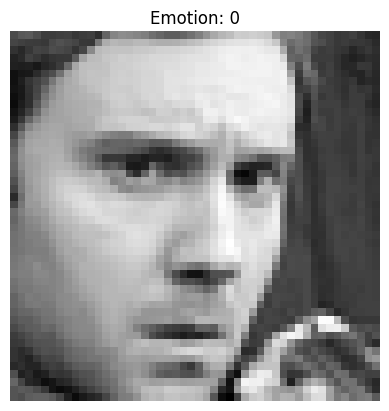

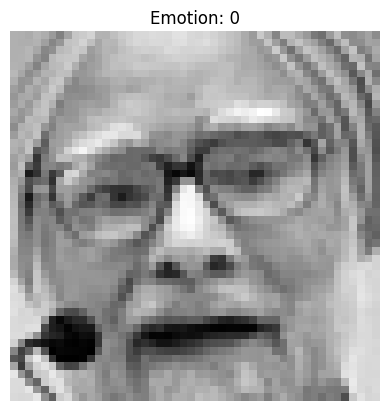

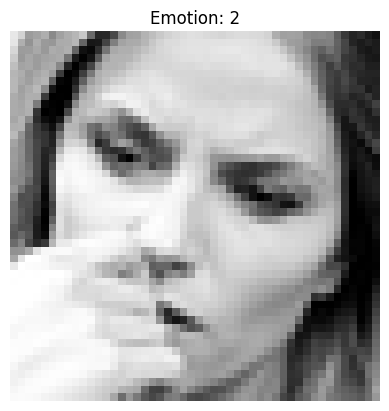

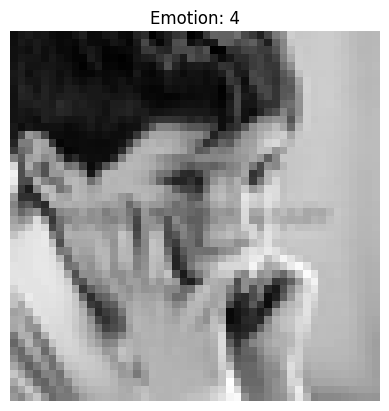

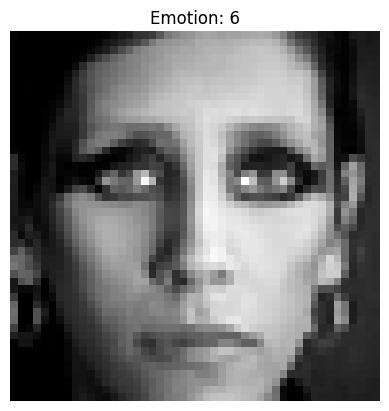

In [4]:
# Load the dataset
df = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')

# Display dataset info
print(df.head())
print(df['emotion'].value_counts())

# Function to visualize an image from the dataset
def plot_image(index):
    emotion_label = df.loc[index, 'emotion']
    pixels = df.loc[index, 'pixels']
    
    # Convert pixel string to a 48x48 grayscale image
    img = np.array(pixels.split(), dtype='uint8').reshape(48, 48)
    
    plt.imshow(img, cmap='gray')
    plt.title(f'Emotion: {emotion_label}')
    plt.axis('off')
    plt.show()

# Visualize a few random images
for i in range(5):
    plot_image(i)

# Add Gaussian Noise

In [5]:
# Function to add Gaussian noise to an image
def add_gaussian_noise(img, mean=0, std=25):
    noise = np.random.normal(mean, std, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 255).astype('uint8')

# Add Gaussian noise to each image
noisy_pixels = []

for i in tqdm(range(len(df))):
    pixels = df.iloc[i]['pixels']
    img = np.array(pixels.split(), dtype='uint8').reshape(48, 48)
    noisy_img = add_gaussian_noise(img)
    noisy_pixels.append(' '.join(map(str, noisy_img.flatten())))

# Add noisy images as a new column
df['noisy_pixels'] = noisy_pixels

# Verify the new column
print(df.head())


100%|██████████| 35887/35887 [00:31<00:00, 1147.12it/s]

   emotion                                             pixels     Usage  \
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training   
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training   
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training   
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training   
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training   

                                        noisy_pixels  
0  31 82 64 61 54 107 113 39 48 40 42 98 116 121 ...  
1  149 153 154 123 161 117 57 127 158 182 205 152...  
2  239 208 166 154 204 98 159 159 174 140 119 71 ...  
3  20 51 47 33 38 37 28 45 30 42 0 33 40 0 16 43 ...  
4  37 14 0 14 11 13 0 20 0 4 0 15 0 0 8 49 67 101...  


In [6]:
# Save the dataset with noisy pixels
df.to_csv('/kaggle/working/fer2013_with_noise.csv', index=False)
print("Dataset with noisy images saved as 'fer2013_with_noise.csv'")


Dataset with noisy images saved as 'fer2013_with_noise.csv'


# Create and Save Noisy Dataset

In [7]:
# Apply Gaussian noise to all images
noisy_pixels = []

for i in tqdm(range(len(df))):
    pixels = df.loc[i, 'pixels']
    img = np.array(pixels.split(), dtype='uint8').reshape(48, 48)
    noisy_img = add_gaussian_noise(img)
    noisy_pixels.append(' '.join(map(str, noisy_img.flatten())))

# Create a new DataFrame for the noisy dataset
df_noisy = df.copy()
df_noisy['pixels'] = noisy_pixels

# Save the noisy dataset
df_noisy.to_csv('/kaggle/working/fer2013_noisy.csv', index=False)
print("Noisy dataset saved as 'fer2013_noisy.csv'")


100%|██████████| 35887/35887 [00:28<00:00, 1273.31it/s]


Noisy dataset saved as 'fer2013_noisy.csv'


# Visualization Function

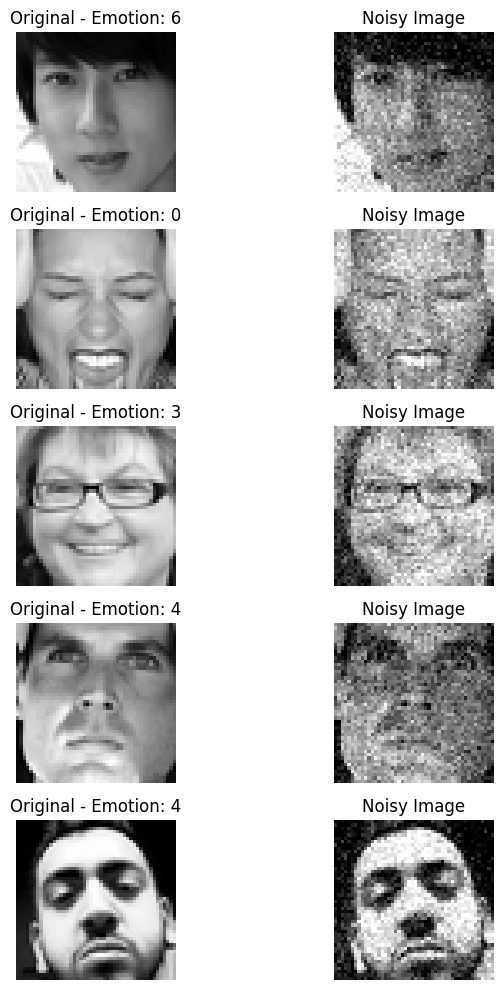

In [8]:
def visualize_noisy_images(df_orig, df_noise, num_images=5):
    indices = np.random.choice(len(df_orig), num_images, replace=False)
    
    fig, axs = plt.subplots(num_images, 2, figsize=(8, 2 * num_images))
    
    for i, idx in enumerate(indices):
        # Original Image
        orig_pixels = df_orig.loc[idx, 'pixels']
        orig_img = np.array(orig_pixels.split(), dtype='uint8').reshape(48, 48)
        
        axs[i, 0].imshow(orig_img, cmap='gray')
        axs[i, 0].set_title(f'Original - Emotion: {df_orig.loc[idx, "emotion"]}')
        axs[i, 0].axis('off')
        
        # Noisy Image
        noisy_pixels = df_noise.loc[idx, 'pixels']
        noisy_img = np.array(noisy_pixels.split(), dtype='uint8').reshape(48, 48)
        
        axs[i, 1].imshow(noisy_img, cmap='gray')
        axs[i, 1].set_title('Noisy Image')
        axs[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 5 random original and noisy image pairs
visualize_noisy_images(df, df_noisy, num_images=5)


# Data Preparation

In [9]:
class FER2013DenoiseDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        noisy_pixels = self.df.iloc[idx]['noisy_pixels']
        original_pixels = self.df.iloc[idx]['pixels']

        noisy_img = np.array(noisy_pixels.split(), dtype='uint8').reshape(48, 48) / 255.0
        original_img = np.array(original_pixels.split(), dtype='uint8').reshape(48, 48) / 255.0
        
        noisy_img = torch.tensor(noisy_img, dtype=torch.float32).unsqueeze(0)
        original_img = torch.tensor(original_img, dtype=torch.float32).unsqueeze(0)

        return noisy_img, original_img


# Create Train and Test Loaders

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = FER2013DenoiseDataset(train_df)
test_dataset = FER2013DenoiseDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify one batch
noisy_imgs, clean_imgs = next(iter(train_loader))
print("Noisy image shape:", noisy_imgs.shape)
print("Clean image shape:", clean_imgs.shape)


Noisy image shape: torch.Size([32, 1, 48, 48])
Clean image shape: torch.Size([32, 1, 48, 48])


# U-NET Model for Denoising

In [11]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.convs(x)

class DeConv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = Conv_block(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((x, skip), dim=1)
        return self.conv(x)

class UNet_Denoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = Conv_block(1, 64)
        self.enc2 = Conv_block(64, 128)
        self.enc3 = Conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = Conv_block(256, 512)
        self.dec3 = DeConv_block(512, 256)
        self.dec2 = DeConv_block(256, 128)
        self.dec1 = DeConv_block(128, 64)
        self.out = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        bottleneck = self.bottleneck(self.pool(enc3))
        dec3 = self.dec3(bottleneck, enc3)
        dec2 = self.dec2(dec3, enc2)
        dec1 = self.dec1(dec2, enc1)
        return self.out(dec1)


# Training

In [15]:
def train_unet(model, train_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    history = {'train_loss': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for noisy_imgs, clean_imgs in train_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            
            optimizer.zero_grad()
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    
    return history



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_model = UNet_Denoiser()
criterion = nn.MSELoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)

# Train the U-Net
history = train_unet(unet_model, train_loader, criterion, optimizer, device, epochs=15)



Epoch [1/15], Loss: 0.006313
Epoch [2/15], Loss: 0.001899
Epoch [3/15], Loss: 0.001815
Epoch [4/15], Loss: 0.001772
Epoch [5/15], Loss: 0.001731
Epoch [6/15], Loss: 0.001720
Epoch [7/15], Loss: 0.001663
Epoch [8/15], Loss: 0.001650
Epoch [9/15], Loss: 0.001633
Epoch [10/15], Loss: 0.001613
Epoch [11/15], Loss: 0.001599
Epoch [12/15], Loss: 0.001585
Epoch [13/15], Loss: 0.001566
Epoch [14/15], Loss: 0.001556
Epoch [15/15], Loss: 0.001547


# Evaluation Metrics

In [16]:
def evaluate_unet(model, test_loader, device):
    model.to(device).eval()
    total_psnr, total_ssim = 0, 0
    num_samples = 0
    
    with torch.no_grad():
        for noisy_imgs, clean_imgs in test_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs)
            
            for i in range(len(outputs)):
                output_img = outputs[i].cpu().numpy().squeeze()
                clean_img = clean_imgs[i].cpu().numpy().squeeze()
                
                total_psnr += psnr(clean_img, output_img, data_range=1)
                total_ssim += ssim(clean_img, output_img, data_range=1)
                num_samples += 1
    
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples
    print(f"Average PSNR: {avg_psnr:.2f}, Average SSIM: {avg_ssim:.4f}")


evaluate_unet(unet_model, test_loader, device)


Average PSNR: 27.59, Average SSIM: 0.9039


# Visualize Results

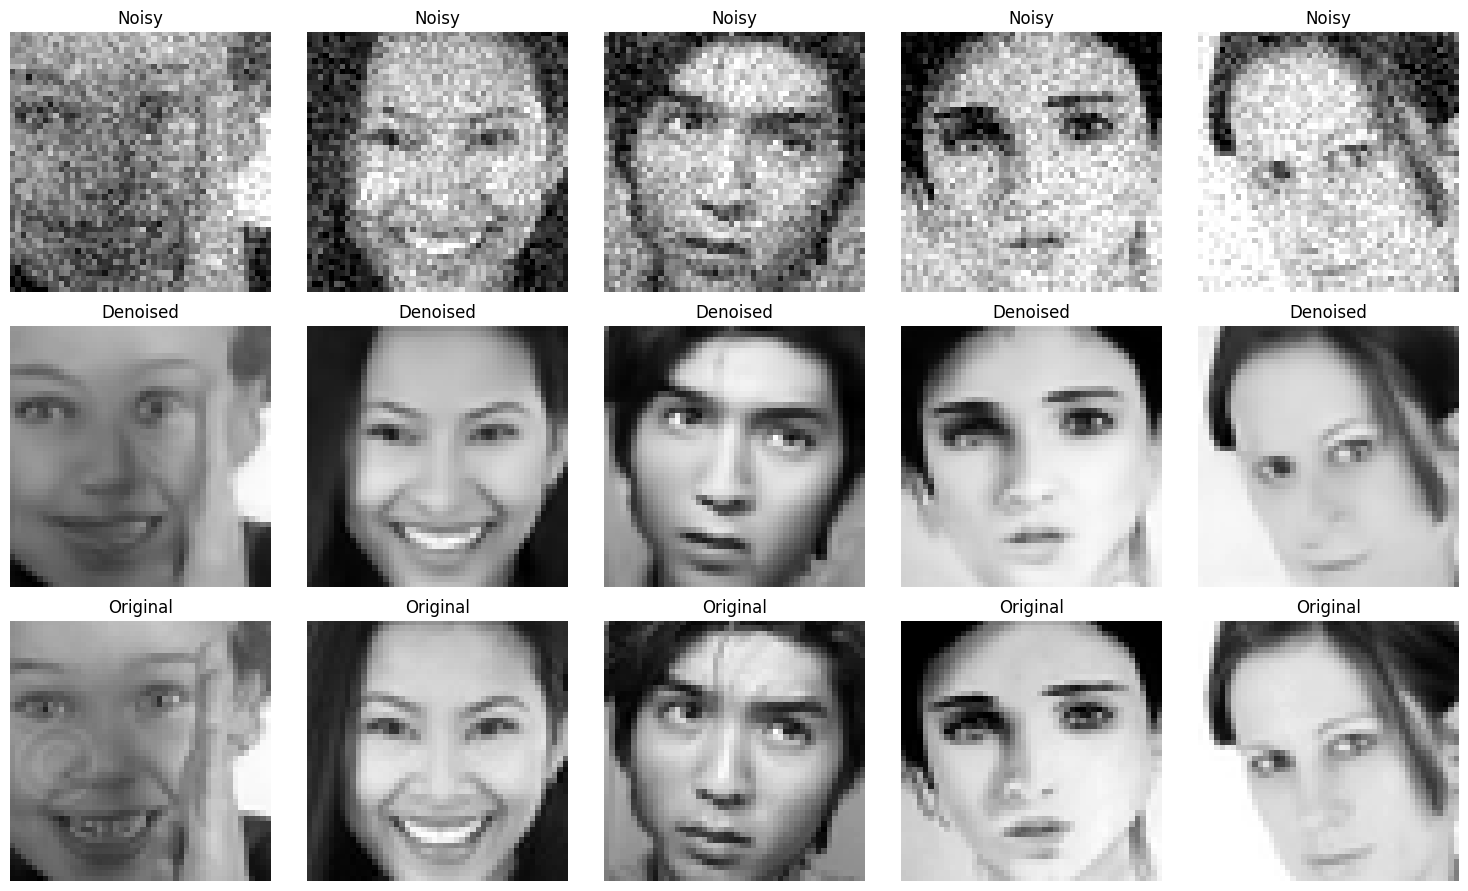

In [17]:
def visualize_denoised_images(model, test_loader, device):
    model.to(device).eval()
    noisy_imgs, clean_imgs = next(iter(test_loader))
    noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
    
    with torch.no_grad():
        outputs = model(noisy_imgs)
    
    fig, axs = plt.subplots(3, 5, figsize=(15, 9))
    
    for i in range(5):
        axs[0, i].imshow(noisy_imgs[i].cpu().squeeze(), cmap='gray')
        axs[0, i].set_title('Noisy')
        axs[0, i].axis('off')
        
        axs[1, i].imshow(outputs[i].cpu().squeeze(), cmap='gray')
        axs[1, i].set_title('Denoised')
        axs[1, i].axis('off')
        
        axs[2, i].imshow(clean_imgs[i].cpu().squeeze(), cmap='gray')
        axs[2, i].set_title('Original')
        axs[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()


visualize_denoised_images(unet_model, test_loader, device)